In [2]:
pip install tinydb

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tinydb import TinyDB, Query
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import tensorflow as tf
from tensorflow import keras
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from transformers import BertTokenizer, TFBertForSequenceClassification
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

1.) Data Ingestion and Storage


In [4]:
db = TinyDB('customer_reviews.json')

# Simulating data generation
np.random.seed(42)
n_samples = 5000

user_ids = np.arange(1, n_samples + 1)
product_ids = np.random.randint(1, 1001, n_samples)
ratings = np.random.randint(1, 6, n_samples)
review_lengths = np.random.randint(10, 200, n_samples)
purchase_amounts = np.random.uniform(10, 1000, n_samples)
customer_ages = np.random.randint(18, 80, n_samples)

# Generate random review text (simplified)
review_texts = [f"This product is {'great' if rating > 3 else 'poor'}. {'Recommended' if rating > 3 else 'Not recommended'}." for rating in ratings]

# Store data in TinyDB
for i in range(n_samples):
    db.insert({
        'user_id': int(user_ids[i]),
        'product_id': int(product_ids[i]),
        'rating': int(ratings[i]),
        'review_length': int(review_lengths[i]),
        'purchase_amount': float(purchase_amounts[i]),
        'customer_age': int(customer_ages[i]),
        'review_text': review_texts[i]
    })

2.) Data Processing and Analysis with Pandas

In [5]:
# Data cleaning and feature engineering
df = pd.DataFrame(db.all())

df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x > 3 else 'negative')
df['review_word_count'] = df['review_text'].apply(lambda x: len(word_tokenize(x)))

3.) Data Visualization

In [6]:
# Static visualization with Matplotlib and Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='purchase_amount', data=df)
plt.title('Purchase Amount Distribution by Sentiment')
plt.savefig('sentiment_purchase_distribution.png')
plt.close()

# Interactive visualization with Plotly
fig = px.scatter(df, x='customer_age', y='purchase_amount', color='sentiment',
                 hover_data=['rating', 'review_word_count'])
fig.write_html('age_purchase_scatter.html')

4.) Statistical Analysis with Statsmodel

In [7]:
import statsmodels.api as sm

X = df[['customer_age', 'review_word_count']]
y = df['purchase_amount']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        purchase_amount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4923
Date:                Sat, 01 Mar 2025   Prob (F-statistic):              0.611
Time:                        22:13:32   Log-Likelihood:                -35345.
No. Observations:                5000   AIC:                         7.070e+04
Df Residuals:                    4997   BIC:                         7.072e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               445.1274     63.63

5.) Machine Learning with Pyspark and Mlib

In [8]:
spark = SparkSession.builder.appName("CustomerReviewAnalysis").getOrCreate()

# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(df)

# Prepare features for ML model
feature_cols = ['customer_age', 'review_word_count', 'purchase_amount']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(spark_df)

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(labelCol="rating", featuresCol="features", numTrees=10)
model = rf.fit(train_data)

# Make predictions and evaluate the model
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="rating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Random Forest Accuracy: {accuracy}")

Random Forest Accuracy: 0.4


In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate using RMSE
evaluator2 = RegressionEvaluator(labelCol="rating", predictionCol="prediction", metricName="rmse")
rmse = evaluator2.evaluate(predictions)
print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 0.9393364366277243


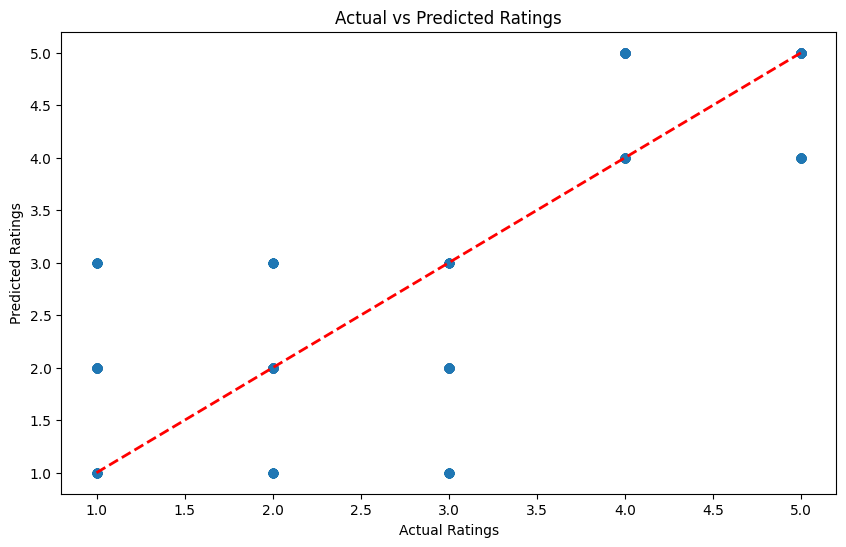

In [10]:
# Convert Spark DataFrame to Pandas
pandas_df = predictions.select("rating", "prediction").toPandas()

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["rating"], pandas_df["prediction"], alpha=0.5)
plt.plot([pandas_df["rating"].min(), pandas_df["rating"].max()], [pandas_df["rating"].min(), pandas_df["rating"].max()], 'r--', lw=2)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings")
plt.show()

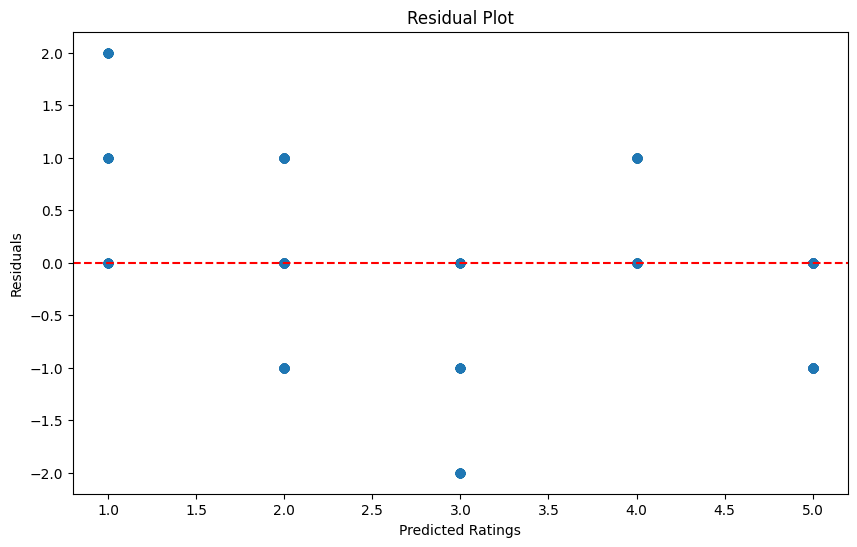

In [11]:
# Create risidual plot
pandas_df["residuals"] = pandas_df["rating"] - pandas_df["prediction"]

plt.figure(figsize=(10, 6))
plt.scatter(pandas_df["prediction"], pandas_df["residuals"], alpha=0.5)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

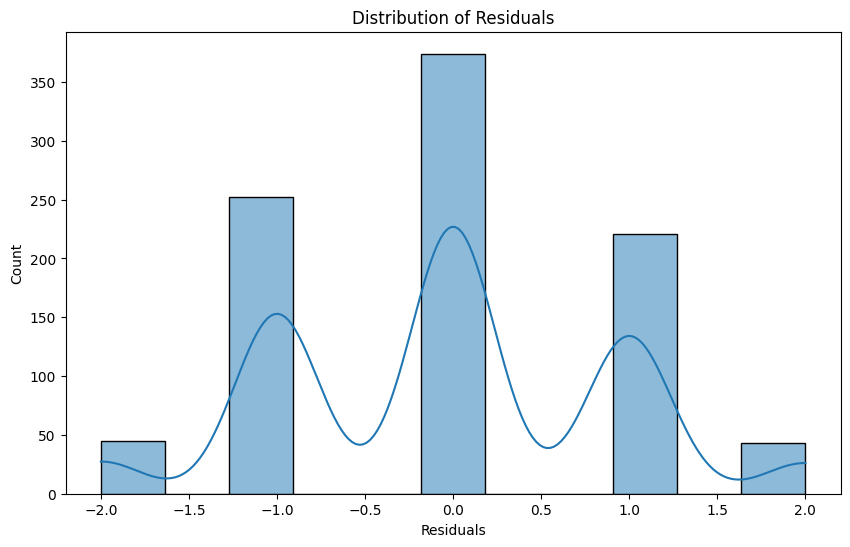

In [12]:
# Create a distribution plot of risiduals
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df["residuals"], kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

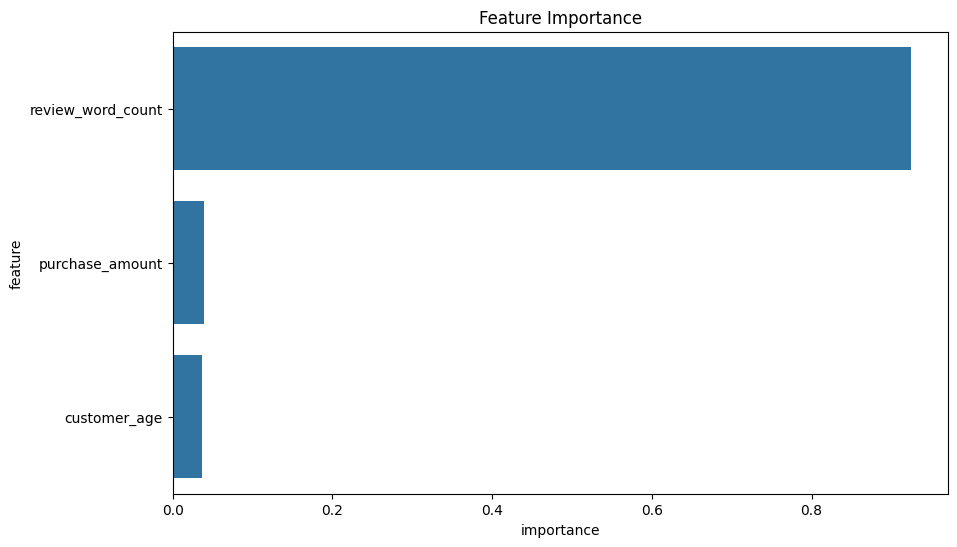

In [14]:
# Feature importance plot for the Random Forest Model
feature_importance = model.featureImportances.toArray()
feature_importance_df = pd.DataFrame({'feature': feature_cols, 'importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title("Feature Importance")
plt.show()

6.) Deep Learning with TensorFlow and Keras

In [ ]:
# Prepare data for deep learning
X_dl = df[['customer_age', 'review_word_count', 'purchase_amount']].values
y_dl = df['rating'].values - 1  # Adjust ratings to start from 0

# Build and train a simple neural network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(3,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_dl, y_dl, epochs=10, validation_split=0.2)

Epoch 1/10
125/125 [==============================] - 2s 4ms/step - loss: 9.9481 - accuracy: 0.2072 - val_loss: 1.8257 - val_accuracy: 0.2120
Epoch 2/10
125/125 [==============================] - 0s 2ms/step - loss: 1.8812 - accuracy: 0.2148 - val_loss: 1.9403 - val_accuracy: 0.1930
Epoch 3/10
125/125 [==============================] - 0s 2ms/step - loss: 1.8310 - accuracy: 0.2245 - val_loss: 1.7803 - val_accuracy: 0.2080
Epoch 4/10
125/125 [==============================] - 1s 4ms/step - loss: 1.8151 - accuracy: 0.2210 - val_loss: 2.0223 - val_accuracy: 0.2060
Epoch 5/10
125/125 [==============================] - 1s 4ms/step - loss: 1.9000 - accuracy: 0.2177 - val_loss: 1.8064 - val_accuracy: 0.2250
Epoch 6/10
125/125 [==============================] - 0s 3ms/step - loss: 1.8155 - accuracy: 0.2130 - val_loss: 1.6466 - val_accuracy: 0.2060
Epoch 7/10
125/125 [==============================] - 0s 4ms/step - loss: 1.9462 - accuracy: 0.2160 - val_loss: 2.2079 - val_accuracy: 0.1980
Epoch 

7.) Natural Language Processing with NLTK and Transformers

In [ ]:
# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))
df['processed_text'] = df['review_text'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.lower() not in stop_words]))

# Use BERT for sentiment analysis
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Prepare data for BERT
inputs = tokenizer(df['processed_text'].tolist(), padding=True, truncation=True, return_tensors="tf")
outputs = model(inputs)
predictions = tf.nn.softmax(outputs.logits, axis=-1)
df['bert_sentiment'] = tf.argmax(predictions, axis=-1).numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.save('deep_learning_model', save_format='tf')

8.) Model Deployement with Streamlit

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

# Load the trained models
@st.cache(allow_output_mutation=True)
def load_models():
    # Load the deep learning model
    dl_model = tf.keras.models.load_model('deep_learning_model')

    # Load the BERT model and tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

    return dl_model, tokenizer, bert_model

dl_model, tokenizer, bert_model = load_models()

2025-02-28 05:20:08.836 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:20:09.303 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-02-28 05:20:09.304 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:20:09.307 
`st.cache` is deprecated and will be removed soon. Please use one of Streamlit's new
caching commands, `st.cache_data` or `st.cache_resource`. More information
[in our docs](https://docs.streamlit.io/develop/concepts/architecture/caching).

**Note**: The behavior of `st.cache` was updated in Streamlit 1.36 to the new caching
logic used by `st.cache_data` and `st.cache_resource`. This might lead to some problems
or unexpected behavior in certain edge cases.

2025-02-28 05:20:09.313 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
202

In [ ]:
# Streamlit app
st.title('Customer Review Analysis')

# Input fields
st.header('Enter Customer Information')
customer_age = st.slider('Customer Age', 18, 80, 30)
review_word_count = st.number_input('Review Word Count', min_value=1, max_value=500, value=50)
purchase_amount = st.number_input('Purchase Amount', min_value=10.0, max_value=1000.0, value=100.0)
review_text = st.text_area('Review Text', 'Enter the customer review here...')

# Predict button
if st.button('Analyze Review'):
    # Deep Learning model prediction
    dl_input = np.array([[customer_age, review_word_count, purchase_amount]])
    dl_prediction = dl_model.predict(dl_input)
    predicted_rating = np.argmax(dl_prediction) + 1  # Add 1 to shift back to 1-5 scale

    # BERT sentiment analysis
    inputs = tokenizer(review_text, padding=True, truncation=True, return_tensors="tf")
    outputs = bert_model(inputs)
    predictions = tf.nn.softmax(outputs.logits, axis=-1)
    bert_sentiment = tf.argmax(predictions, axis=-1).numpy()[0]
    sentiment = 'Positive' if bert_sentiment == 1 else 'Negative'

    # Display results
    st.header('Analysis Results')
    st.write(f'Predicted Rating: {predicted_rating}/5')
    st.write(f'Sentiment Analysis: {sentiment}')

2025-02-28 05:22:23.648 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.661 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.664 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.667 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.670 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.673 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-28 05:22:23.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
# Run streamlit run app.py in terminal